# Demo that model fails in extrapolation range


## Import modules

In [1]:
import pickle
import os

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import helper

# Dynamic GPU memory allocation: For local prototyping, don't block GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

2023-07-13 12:43:41.158873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 12:43:41.725488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-13 12:43:42.731297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-13 12:43:42.749262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

## Load trained forward model and data scaler

Here we load the pre-trained model and the data scaler

In [2]:
data_path = 'datasets/dataset1_random.h5'
model_path = 'models/fwd_model_resnet.h5'

# load data scalers
scaler_mat, scaler_thick = pickle.load(
    open('{}_scalers.pkl'.format(os.path.splitext(data_path)[0]), 'rb'))

# load pretrained forward model
fwd_model = keras.models.load_model(model_path)

2023-07-13 12:43:43.507480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-13 12:43:43.507688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-13 12:43:43.507805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## generate interpolation and extrapolation samples

In [3]:
rng = np.random.default_rng()

N_samples = 4
wavelengths = np.linspace(500, 1500, 64)
N_layers = 5


# interpolation regime: parameter ranges
thickness_limits = [20, 180]   # thickness limits (in nm)
eps_limits = [1.3**2, 2.5**2]  # permittivity limits

_mat_list = []
_thick_list = []
R_list_interpolate = []
for i in tqdm(range(N_samples)):
    # random values for thickness and material ref.index
    thicknesses = rng.random(size=N_layers) * \
        np.diff(thickness_limits) + thickness_limits[0]
    materials = rng.random(size=N_layers) * np.diff(eps_limits) + eps_limits[0]

    R_list_interpolate.append(helper.calc_R(thicknesses, materials, wavelengths))
    _mat_list.append(materials)
    _thick_list.append(thicknesses)

geo_interpolate = helper.scale_and_combine_Rspec_data(
    _mat_list, _thick_list, scaler_mat, scaler_thick)


# extrapolation regime 1: larger parameter values
thickness_limits = [180, 200]  # thickness limits (in nm)
eps_limits = [2.5**2, 3**2]    # permittivity limits

_mat_list = []
_thick_list = []
R_list_extrapolate1 = []
for i in tqdm(range(N_samples)):
    # random values for thickness and material ref.index
    thicknesses = rng.random(size=N_layers) * \
        np.diff(thickness_limits) + thickness_limits[0]
    materials = rng.random(size=N_layers) * np.diff(eps_limits) + eps_limits[0]
    
    R_list_extrapolate1.append(helper.calc_R(thicknesses, materials, wavelengths))
    _mat_list.append(materials)
    _thick_list.append(thicknesses)

geo_extrapolate1 = helper.scale_and_combine_Rspec_data(
    _mat_list, _thick_list, scaler_mat, scaler_thick)


# extrapolation regime 2: smaller parameter values
thickness_limits = [10, 20]  # thickness limits (in nm)
eps_limits = [1.1**2, 1.3**2]    # permittivity limits

_mat_list = []
_thick_list = []
R_list_extrapolate2 = []
for i in tqdm(range(N_samples)):
    # random values for thickness and material ref.index
    thicknesses = rng.random(size=N_layers) * \
        np.diff(thickness_limits) + thickness_limits[0]
    materials = rng.random(size=N_layers) * np.diff(eps_limits) + eps_limits[0]
    
    R_list_extrapolate2.append(helper.calc_R(thicknesses, materials, wavelengths))
    _mat_list.append(materials)
    _thick_list.append(thicknesses)

geo_extrapolate2 = helper.scale_and_combine_Rspec_data(
    _mat_list, _thick_list, scaler_mat, scaler_thick)

100%|██████████| 4/4 [00:00<00:00, 105.40it/s]


2023-07-13 12:43:45.567091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-13 12:43:46.206449: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<function matplotlib.pyplot.show(close=None, block=None)>

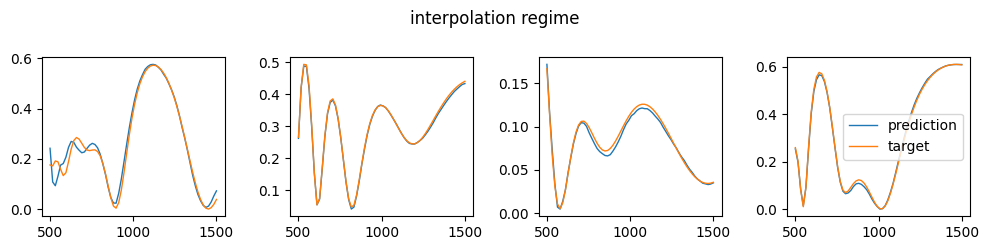

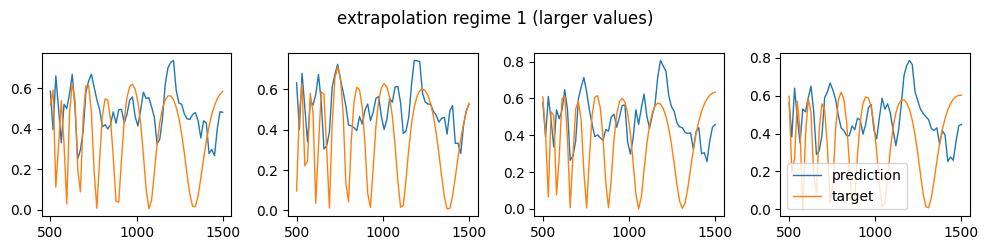

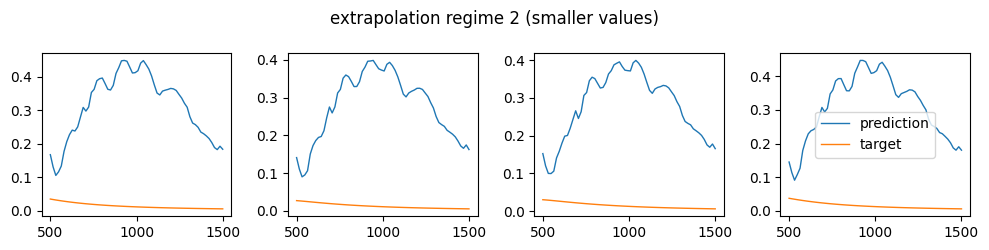

In [4]:
# plot interpolation samples
pred_inter = fwd_model.predict(geo_interpolate, verbose=0)

plt.figure(figsize=(10, 2.5))
plt.suptitle("interpolation regime")
for i in range(len(geo_interpolate)):
    plt.subplot(1, 4, i+1)
    plt.plot(wavelengths, pred_inter[i], label='prediction', linewidth=1)
    plt.plot(wavelengths, R_list_interpolate[i], label='target', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show


# plot extrapolation samples - part 1/1
pred_extra1 = fwd_model.predict(geo_extrapolate1, verbose=0)

plt.figure(figsize=(10, 2.5))
plt.suptitle("extrapolation regime 1 (larger values)")
for i in range(len(geo_extrapolate1)):
    plt.subplot(1, 4, i+1)
    plt.plot(wavelengths, pred_extra1[i], label='prediction', linewidth=1)
    plt.plot(wavelengths, R_list_extrapolate1[i], label='target', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show


# plot extrapolation samples - part 2/2
pred_extra2 = fwd_model.predict(geo_extrapolate2, verbose=0)

plt.figure(figsize=(10, 2.5))
plt.suptitle("extrapolation regime 2 (smaller values)")
for i in range(len(geo_extrapolate2)):
    plt.subplot(1, 4, i+1)
    plt.plot(wavelengths, pred_extra2[i], label='prediction', linewidth=1)
    plt.plot(wavelengths, R_list_extrapolate2[i], label='target', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show

## Statistics

Now we generate samples at the "edge" of the dataset range, which are partly inside, partly outside of the geometry values used for training. Like this we assess the error increase as function of the amount of extrapolation.

In [5]:
N_samples = 10000

# border of extrapolation regime (larger parameter values side)
thickness_limits = [100, 230]  # thickness limits (in nm)
eps_limits = [0.8**2, 3.0**2]    # permittivity limits

_mat_list = []
_thick_list = []
R_list_extrapolate = []
for i in tqdm(range(N_samples)):
    # random values for thickness and material ref.index
    thicknesses = rng.random(size=N_layers) * \
        np.diff(thickness_limits) + thickness_limits[0]
    materials = rng.random(size=N_layers) * np.diff(eps_limits) + eps_limits[0]
    
    R_list_extrapolate.append(helper.calc_R(thicknesses, materials, wavelengths))
    _mat_list.append(materials)
    _thick_list.append(thicknesses)

geo_extrapolate = helper.scale_and_combine_Rspec_data(
    _mat_list, _thick_list, scaler_mat, scaler_thick)

# predict
pred_extra = fwd_model.predict(geo_extrapolate)

100%|██████████| 10000/10000 [01:35<00:00, 105.17it/s]


313/313 [==============================] - 2s 5ms/step


In [15]:
# calcualte the prediction error
err = np.squeeze(pred_extra) - np.squeeze(R_list_extrapolate)
err_mean = np.mean(np.abs(err), axis=-1)
err_max = np.max(np.abs(err), axis=-1)


# Calcuate the amount of parameter excess into extrapolation zone
max_interpol_mat = 2.5**2
max_interpol_thick = 180

mat_norm = np.array(_mat_list) / max_interpol_mat
thick_norm = np.array(_thick_list) / max_interpol_thick

excess_mat = mat_norm.copy()
excess_mat -= 1
excess_mat[excess_mat<0] = 0
excess_mat = np.sum(excess_mat, axis=1)
excess_mat

excess_thick = thick_norm.copy()
excess_thick -= 1
excess_thick[excess_thick<0] = 0
excess_thick = np.sum(excess_thick, axis=1)
excess_thick

excess_avg = (excess_mat + excess_thick) / 10  # average: divide by nr of parameters

# calculate average error in successive regions of the extrapolation zone
N_zones = 30
ex_list = np.linspace(0, excess_avg.max(), N_zones, endpoint=False)
dex = ex_list[1] - ex_list[0]

err_ex = []
err_std = []
for ex in ex_list:
    err_ex.append(np.mean(err_mean[np.logical_and(ex<excess_avg, excess_avg<ex+dex)]))
    err_std.append(np.std(err_mean[np.logical_and(ex<excess_avg, excess_avg<ex+dex)]))
err_ex = np.array(err_ex)*100
err_std = np.array(err_std)*100

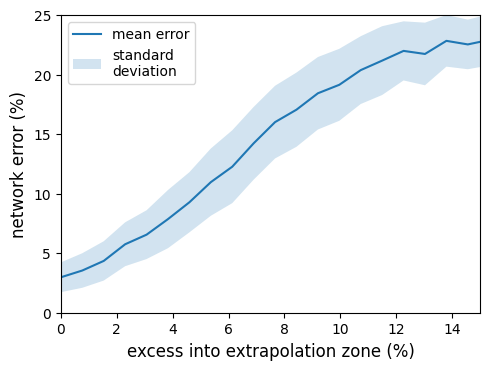

In [23]:
# plot the results

plt.figure(figsize=(5,3.75))

plt.plot(ex_list*100, err_ex, label='mean error')
plt.fill_between(ex_list*100, err_ex-err_std/2, err_ex+err_std/2, alpha=0.2, label='standard\ndeviation')

plt.xlabel('excess into extrapolation zone (%)', fontsize=12)
plt.ylabel('network error (%)', fontsize=12)
plt.tight_layout()
plt.xlim(0, 15)
plt.ylim(0, 25)
plt.legend()
plt.show()